## Loan Prediction System


##### Overview

This project aims to develop an end-to-end Loan Prediction System, including data preprocessing, model development, and deployment. The system predicts whether a loan application should be approved or not based on various factors.

Data source : https://www.kaggle.com/datasets/burak3ergun/loan-data-set


In [305]:
!pip install pandas --quiet
!pip install numpy --quiet
!pip install seaborn --quiet
!pip install scikit-learn --quiet
!pip install pytest-warnings --quiet
!pip install xgboost --quiet
!pip install wandb --quiet

In [306]:
# Import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder 
import wandb
%matplotlib inline

import warnings

In [307]:
# Set your wandb API key
wandb.login(key="454b8a179eb1f72e0bdee6435859cf589da9a62b")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\HP\.netrc


True

In [308]:
wandb.init(project='loan_prediction_project', config={})


### 2. Exploration Data and Analysis - Understanding dataset


In [310]:
# display dataset 
dataset_df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [311]:
# Dataset information
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [312]:
# The summary statistics of the dataset
dataset_df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [313]:
# This function will return a Series containing the count of missing values for each column in `dataset_df`.
def missing_values(data):
    null_values = data.isnull().sum()
    return null_values

missing_values(dataset_df)


Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

##### <ins>Data Cleaning - drop some columns</ins>


In [314]:
# drop loadID and dependents columns
dataset_df.drop(['Loan_ID', 'Dependents'], axis=1, inplace=True)
dataset_df.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


##### <ins>Data Cleaning - fill missing values using modes</ins>


In [315]:
# Fill missing values in these columns with their respective modes.

# Selecting the columns with missing values
selected_columns = ["Gender", "Married", "Self_Employed"]

# Iterating over each selected column
for column_name in selected_columns:
    # Calculating the mode (most frequent value) of the column
    column_mode = dataset_df[column_name].mode().iloc[0]
    
    # Filling missing values in the column with the calculated mode
    dataset_df[column_name] = dataset_df[column_name].fillna(column_mode)


<small>1. Typically used for categorical or ordinal data where values represent categories or levels.</small> <br><small>2. Useful when dealing with categorical variables like gender, marital status, employment status, etc.</small><br>
<small>3. Filling missing values with the mode helps preserve the distribution and frequency of existing categories in the dataset.</small><br>


In [316]:
missing_values(dataset_df)

Gender                0
Married               0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

##### <ins>Data Cleaning - fill missing values using means</ins>


In [318]:
dataset_df.isna().sum()

Gender               0
Married              0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

##### <ins>Data visualization - Understanding correlations</ins>


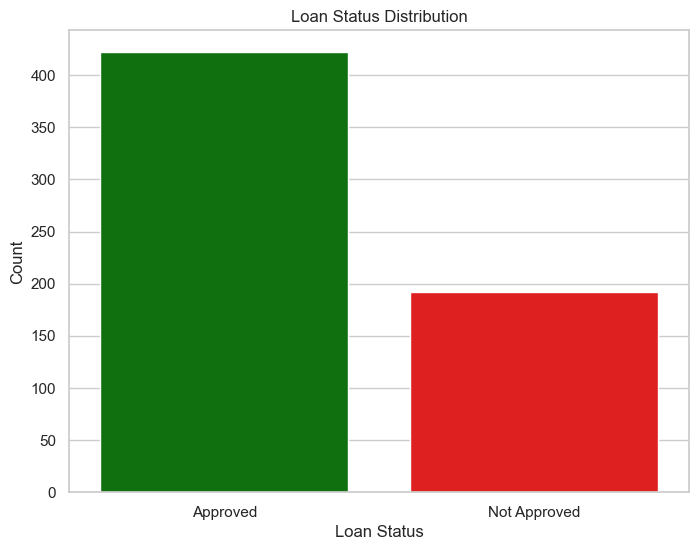

In [319]:

def visualize_loan_status(data):
    # Replace 'Y' with 'Approved' and 'N' with 'Not Approved'
    data['Loan_Status'] = data['Loan_Status'].replace({'Y': 'Approved', 'N': 'Not Approved'})

    # Count plot for Loan_Status with hue assigned to x variable
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Loan_Status', hue='Loan_Status', data=data, palette={'Approved': 'green', 'Not Approved': 'red'}, legend=False)
    plt.title('Loan Status Distribution')
    plt.xlabel('Loan Status')
    plt.ylabel('Count')
    plt.show()

# Call the function with the dataset_df DataFrame
visualize_loan_status(dataset_df.copy())


**Note:** <small>The loan of 422(around 69%) people out of 614 was approved.</small>


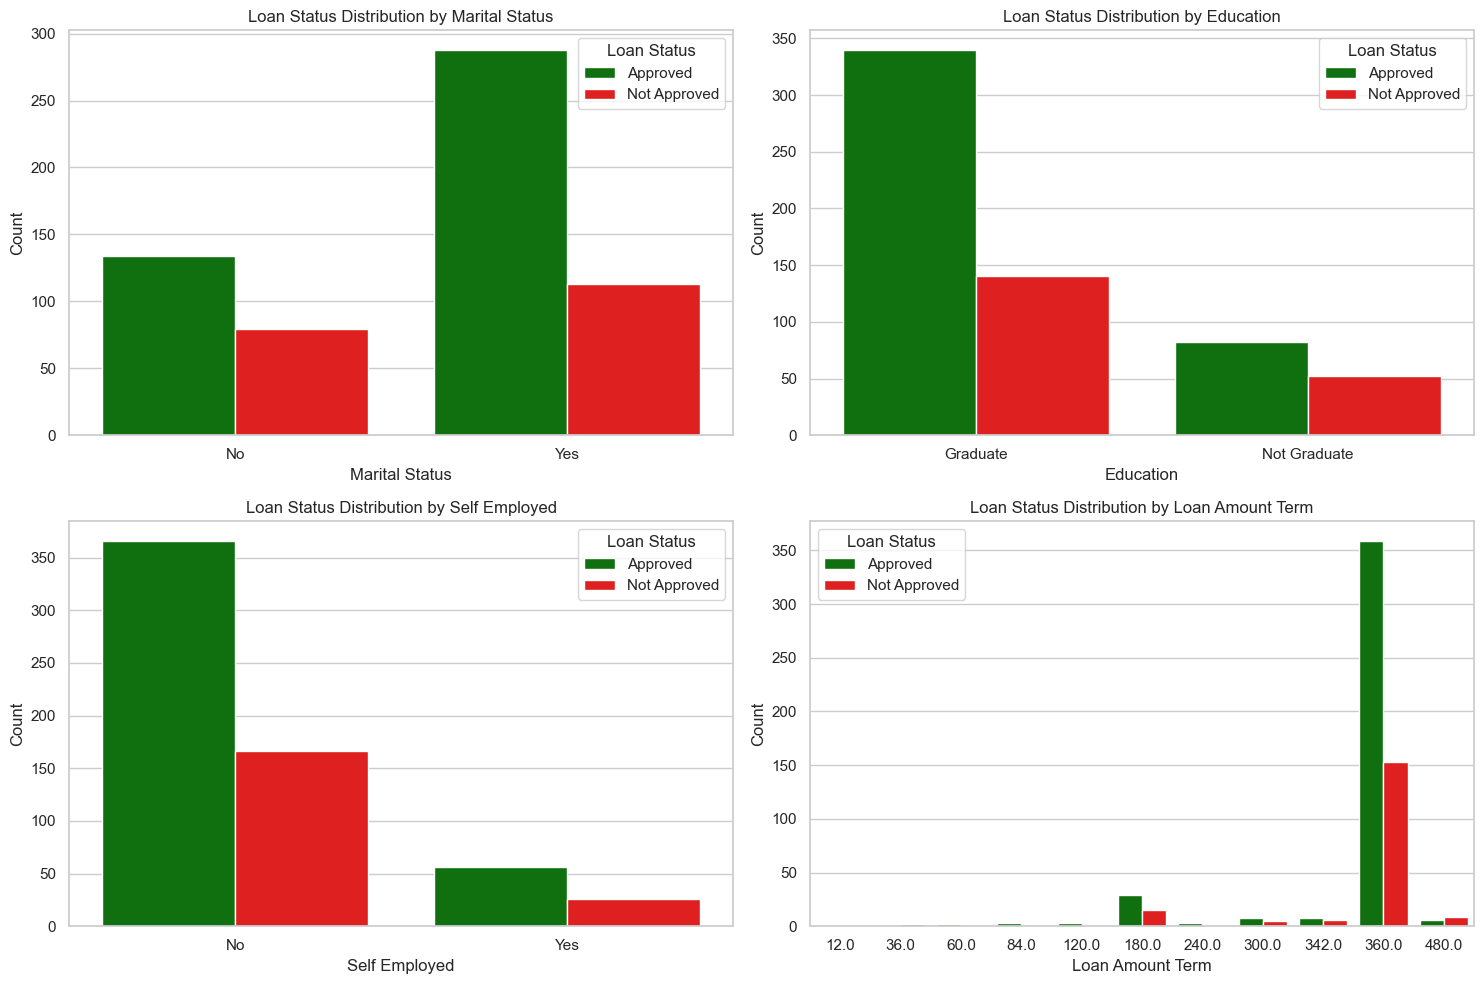

In [320]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_loan_status(data):
    # Replace 'Y' with 'Approved' and 'N' with 'Not Approved' in Loan_Status
    data['Loan_Status'] = data['Loan_Status'].replace({'Y': 'Approved', 'N': 'Not Approved'})

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Plot for Married vs Loan_Status
    sns.countplot(ax=axes[0, 0], x='Married', hue='Loan_Status', data=data, palette={'Approved': 'green', 'Not Approved': 'red'})
    axes[0, 0].set_title('Loan Status Distribution by Marital Status')
    axes[0, 0].set_xlabel('Marital Status')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].legend(title='Loan Status')

    # Plot for Education vs Loan_Status
    sns.countplot(ax=axes[0, 1], x='Education', hue='Loan_Status', data=data, palette={'Approved': 'green', 'Not Approved': 'red'})
    axes[0, 1].set_title('Loan Status Distribution by Education')
    axes[0, 1].set_xlabel('Education')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].legend(title='Loan Status')

    # Plot for Self_Employed vs Loan_Status
    sns.countplot(ax=axes[1, 0], x='Self_Employed', hue='Loan_Status', data=data, palette={'Approved': 'green', 'Not Approved': 'red'})
    axes[1, 0].set_title('Loan Status Distribution by Self Employed')
    axes[1, 0].set_xlabel('Self Employed')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].legend(title='Loan Status')
    
    # Plot for Loan_Amount_Term vs Loan_Status
    sns.countplot(ax=axes[1, 1], x='Loan_Amount_Term', hue='Loan_Status', data=data, palette={'Approved': 'green', 'Not Approved': 'red'})
    axes[1, 1].set_title('Loan Status Distribution by Loan Amount Term')
    axes[1, 1].set_xlabel('Loan Amount Term')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].legend(title='Loan Status')
    
    plt.tight_layout()
    plt.show()

# Call the function with the dataset_df DataFrame
visualize_loan_status(dataset_df.copy())


- <small>Around 65% people are married.</small>
- <small>Around 80% of the applicants are graduate.</small>
- <small>Around 15% applicants in the dataset are self employed.</small>


In [321]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_income_by_education(data):
    """
    Plot ApplicantIncome by Education.

    Parameters:
    data (DataFrame): Input DataFrame containing 'ApplicantIncome' and 'Education' columns.
    """
    # Set the style of seaborn
    sns.set(style="whitegrid")

    # Create a boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Education', y='ApplicantIncome', data=data)
    plt.title('Applicant Income by Education Level')
    plt.xlabel('Education Level')
    plt.ylabel('Applicant Income')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.show()


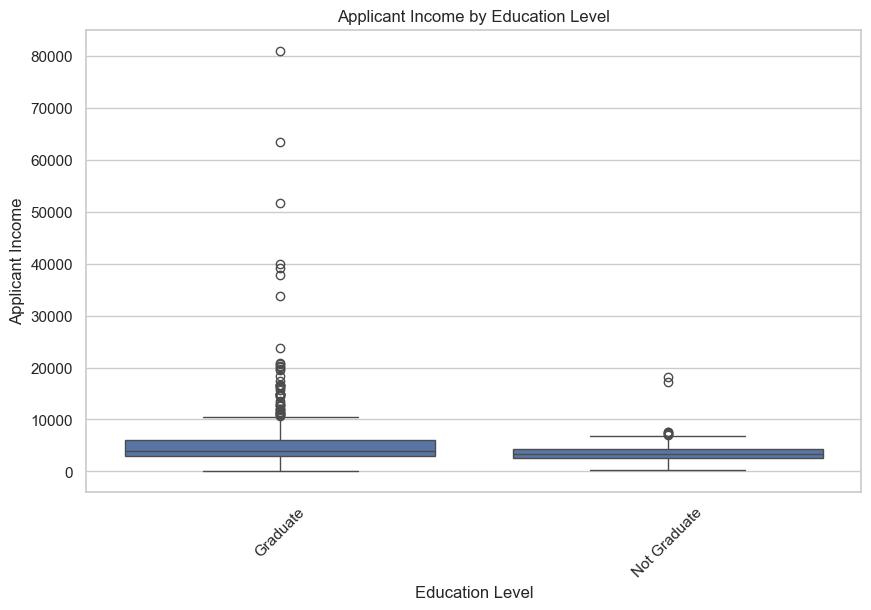

In [322]:
plot_income_by_education(dataset_df)


In [323]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_income_distribution(data):
    """
    Plot box plot and density plot for ApplicantIncome.

    Parameters:
    data (DataFrame): Input DataFrame containing 'ApplicantIncome' column.
    """
    # Set the style of seaborn
    sns.set(style="whitegrid")

    # Create a figure with two subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

    # Plot box plot
    sns.boxplot(x=data['ApplicantIncome'], ax=axes[0])
    axes[0].set_title('Applicant Income Box Plot')
    axes[0].set_xlabel('Applicant Income')

    # Plot density plot
    sns.histplot(data['ApplicantIncome'], kde=True, ax=axes[1], color='skyblue')
    axes[1].set_title('Applicant Income Density Plot')
    axes[1].set_xlabel('Applicant Income')
    axes[1].set_ylabel('Density')

    # Adjust layout
    plt.tight_layout()
    plt.show()


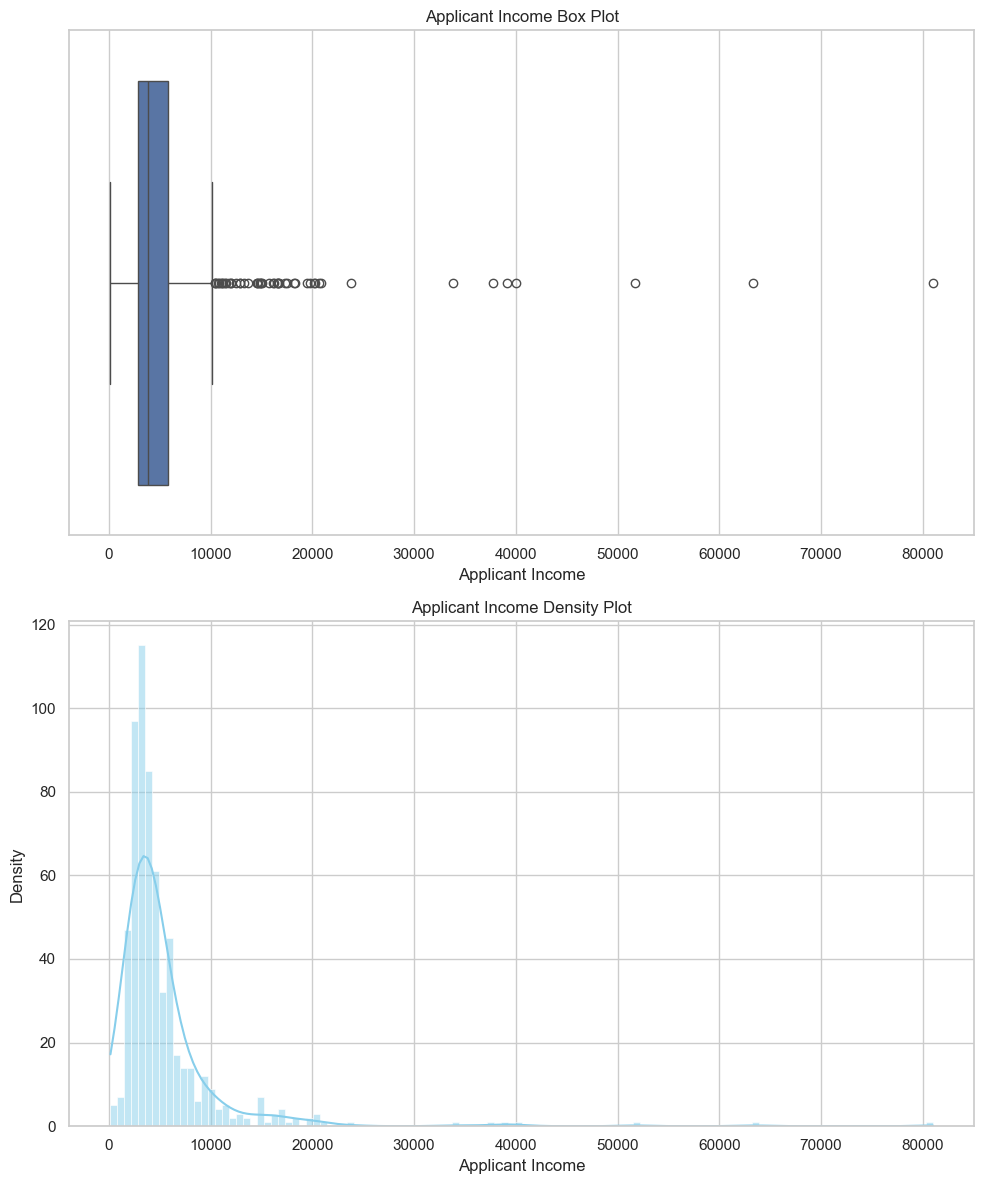

In [324]:
plot_income_distribution(dataset_df)


- Box plot shows applicant income spread: median around $35k, more high-income outliers. Density plot confirms: more applicants have lower incomes.


In [325]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_numeric_correlation_heatmap(data):
    """
    Plot a correlation heatmap for the numeric columns of the given dataset.

    Parameters:
    data (DataFrame): The input dataset.

    Returns:
    None
    """
    # Select only numeric columns
    numeric_data = data.select_dtypes(include='number')

    if numeric_data.empty:
        print("No numeric columns found in the dataset.")
        return
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(numeric_data.corr(), vmax=0.8, square=True, cmap='BuPu')
    plt.title('Correlation Matrix Heatmap (Numeric Columns)')
    plt.show()


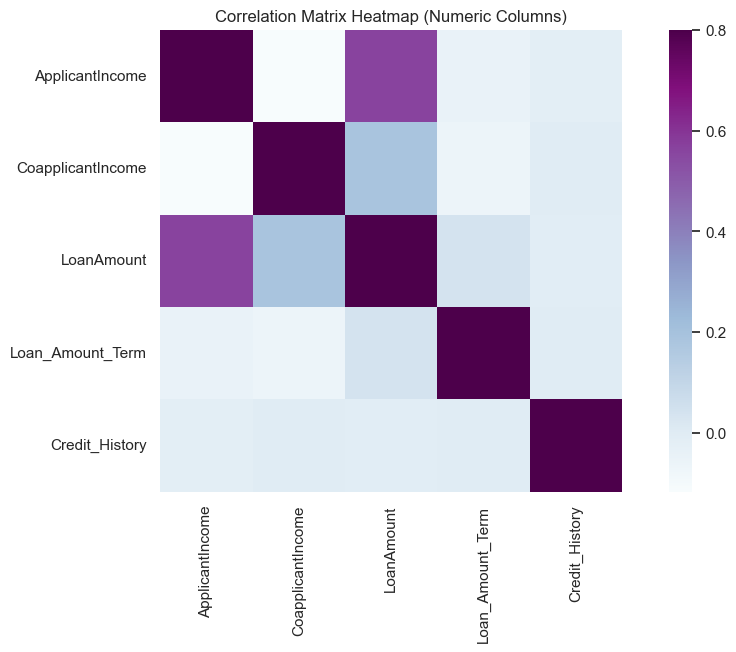

In [326]:
plot_numeric_correlation_heatmap(dataset_df)


- Heatmap shows connections between loan factors. Dark blue = strong positive connection (e.g. high income applicant, high income co-applicant). Light yellow = weak connection (e.g. loan amount, credit history).


##### <ins>Perform categorical encoding</ins>


In [327]:
# List of categorical columns to encode
categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

def encode_categorical_features(data, categorical_columns):
    """
    Encode categorical features using OrdinalEncoder.

    Parameters:
    data (DataFrame): The DataFrame containing the categorical features.
    categorical_columns (list): A list of column names corresponding to the categorical features.

    Returns:
    DataFrame: The DataFrame with categorical features encoded.
    """
    # Initialize the OrdinalEncoder
    ord_enc = OrdinalEncoder() 

    # Fit and transform the selected columns
    data[categorical_columns] = ord_enc.fit_transform(data[categorical_columns])

    return data

# Call the function to encode categorical features
dataset_df_encoded = encode_categorical_features(dataset_df.copy(), categorical_columns)

# Display the first few rows of the transformed DataFrame
dataset_df_encoded.head()


,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1.0
1,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0.0
2,1.0,1.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1.0
3,1.0,1.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1.0
4,1.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1.0


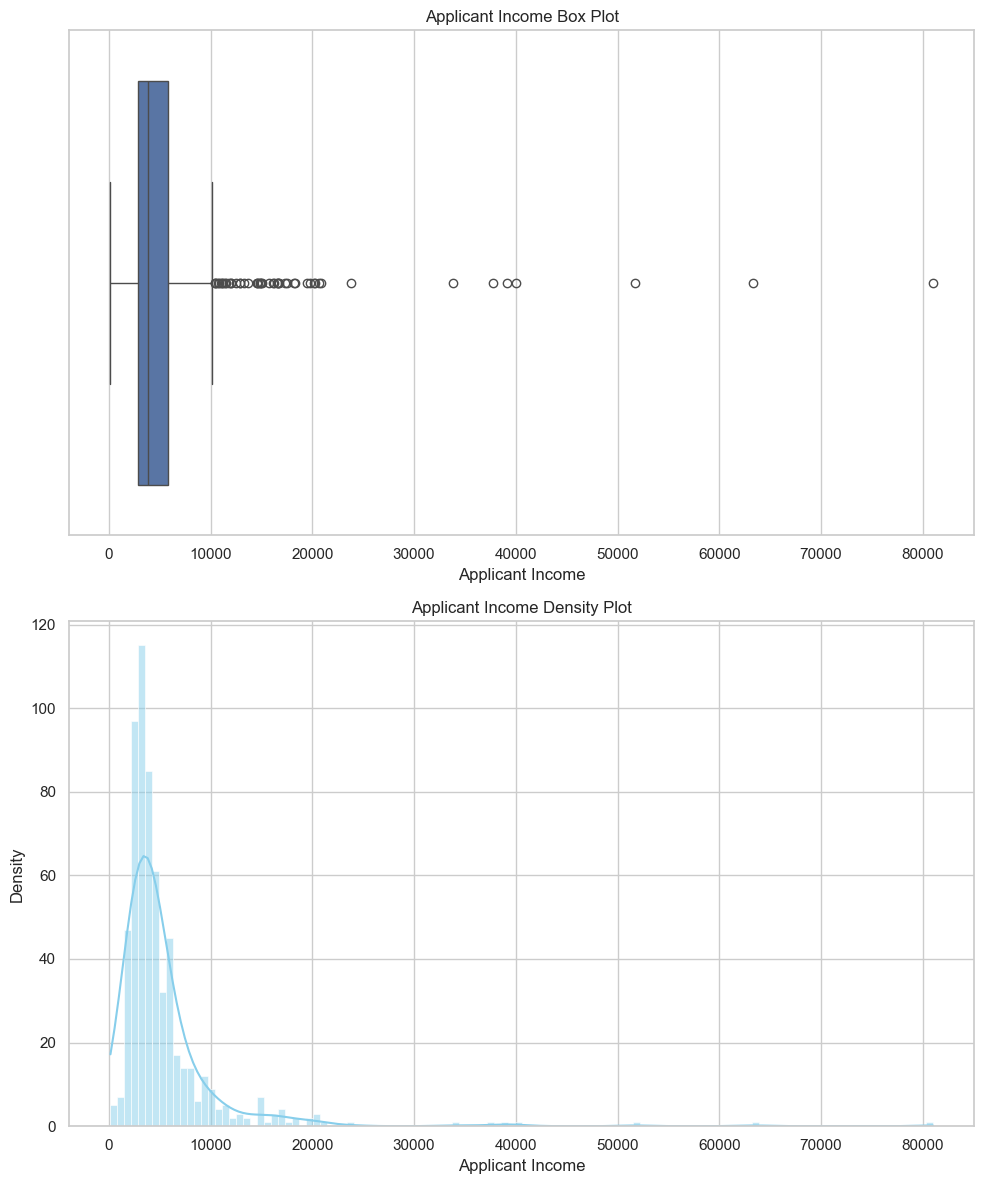

In [328]:
plot_income_distribution(dataset_df)


In [329]:
# Call the function to encode categorical features
dataset_df_encoded = encode_categorical_features(dataset_df.copy(), categorical_columns)

# Display the first few rows of the transformed DataFrame
dataset_df_encoded.head()


,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1.0,0.0,0.0,0.0,5849,0.0,146.412162,360.0,1.0,2.0,1.0
1,1.0,1.0,0.0,0.0,4583,1508.0,128.000000,360.0,1.0,0.0,0.0
2,1.0,1.0,0.0,1.0,3000,0.0,66.000000,360.0,1.0,2.0,1.0
3,1.0,1.0,1.0,0.0,2583,2358.0,120.000000,360.0,1.0,2.0,1.0
4,1.0,0.0,0.0,0.0,6000,0.0,141.000000,360.0,1.0,2.0,1.0


<small>**Note**: `The OrdinalEncoder` is used when there's an inherent order among categories, and use `one-hot encoding` or `dummy encoding`when categories are nominal (unordered) or when you want to avoid implying any ordinal relationship between categories.<small>


##### <ins>Convert the dataframe in integer format</ins>


In [330]:
#  convert categorical variables in of DataFrame to integer type:

def convert_categorical_to_int(df):

    # Create a copy of the DataFrame to avoid modifying the original data
    modified_df = df.copy()

    # Define the list of categorical columns to be converted
    categorical_columns = ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

    # Convert each categorical column to integer type
    for col in categorical_columns:
        # Use astype('category').cat.codes to convert categories to numerical codes
        modified_df[col] = modified_df[col].astype('category').cat.codes

    return modified_df


In [331]:
# Call the function to convert categorical columns to integer type
convert_categorical_to_int(dataset_df_encoded)


,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,5849,0.0,146.412162,360.0,1.0,2,1
1,1,1,0,0,4583,1508.0,128.000000,360.0,1.0,0,0
2,1,1,0,1,3000,0.0,66.000000,360.0,1.0,2,1
3,1,1,1,0,2583,2358.0,120.000000,360.0,1.0,2,1
4,1,0,0,0,6000,0.0,141.000000,360.0,1.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,2900,0.0,71.000000,360.0,1.0,0,1
610,1,1,0,0,4106,0.0,40.000000,180.0,1.0,0,1
611,1,1,0,0,8072,240.0,253.000000,360.0,1.0,2,1
612,1,1,0,0,7583,0.0,187.000000,360.0,1.0,2,1


### 3. Training the Model


In [332]:
from sklearn.model_selection import train_test_split

def perform_train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Perform train-test split on the given features and target variable.

    Parameters:
    X (pd.DataFrame): Features.
    y (pd.Series): Target variable.
    test_size (float or int): Proportion of the dataset to include in the test split.
    random_state (int or None): Seed for random number generator.

    Returns:
    tuple: Tuple containing X_train, X_test, y_train, and y_test.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test


In [333]:

X = dataset_df_encoded.drop("Loan_Status", axis=1)
y = dataset_df_encoded["Loan_Status"]

X_train, X_test, y_train, y_test = perform_train_test_split(X, y, test_size=0.2, random_state=2)


In [334]:

# Print the shapes of train and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (491, 10)
y_train shape: (491,)
X_test shape: (123, 10)
y_test shape: (123,)


##### A. <ins>`Gaussian Naive Bayes classifier (GaussianNB) from scikit-learn to train a model and make predictions.`</ins>


In [335]:
from sklearn.naive_bayes import GaussianNB

def train_and_predict(classifier, X_train, y_train, X_test):
    """
    Train the classifier using the training data and make predictions on the test data.

    Parameters:
    classifier: The classifier object (e.g., GaussianNB).
    X_train (pd.DataFrame or np.array): Features of the training data.
    y_train (pd.Series or np.array): Target variable of the training data.
    X_test (pd.DataFrame or np.array): Features of the test data.

    Returns:
    np.array: Predicted labels for the test data.
    """
    # Train the classifier using the training data
    classifier.fit(X_train, y_train)

    # Make predictions on the test data
    pred = classifier.predict(X_test)

    return pred

# Create an instance of Gaussian Naive Bayes classifier
gfc = GaussianNB()

# Use the train_and_predict function to train the classifier and make predictions
pred1 = train_and_predict(gfc, X_train, y_train, X_test)

In [336]:
pred1


array([0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 1., 1.])

<ins> `Calculate metrics precision_score, recall_score, accuracy_score.`</ins>


In [337]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

def calculate_metrics(y_true, y_pred):
    """
    Calculate precision, recall, and accuracy scores.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.

    Returns:
    tuple: Tuple containing precision, recall, and accuracy scores.
    """
    # Calculate precision, recall, and accuracy scores
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    return pre, rec, acc

In [338]:

def loss(y_true, y_pred):
    """
    Print precision, recall, and accuracy scores.

    Parameters:
    y_true (array-like): True labels.
    y_pred (array-like): Predicted labels.
    """
    # Calculate precision, recall, and accuracy scores
    pre, rec, acc = calculate_metrics(y_true, y_pred)
    
    # Print the scores
    print("Precision:", pre)
    print("Recall:", rec)
    print("Accuracy:", acc)
    
    # Log the metrics to wandb
    wandb.log({"Precision": pre, "Recall": rec, "Accuracy": acc})


In [339]:
# Assuming y_test and pred1 are your true and predicted labels, respectively
loss(y_test, pred1)

Precision: 0.7766990291262136
Recall: 0.9523809523809523
Accuracy: 0.7804878048780488


- **Precision:** Out of all the positive predictions made by the model, 77.67% were correct.
- **Recall:** The model correctly identified 95.24% of all actual positive instances.
- **Accuracy:** The overall accuracy of the model in predicting both positive and negative instances is 78.05%.


##### <ins>B. `Perform grid search using Support Vector Classifier (SVC).`</ins>


In [340]:
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 

def perform_grid_search(X_train, y_train):
    """
    Perform grid search using Support Vector Classifier (SVC).

    Parameters:
    X_train (array-like): Training features.
    y_train (array-like): Training labels.

    Returns:
    GridSearchCV: Grid search object containing the results.
    """
    # defining parameter range
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf']} 
    
    # Initialize GridSearchCV
    grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
    
    # Perform grid search
    grid.fit(X_train, y_train)
    
    return grid

In [341]:
# Perform grid search
grid_search_result = perform_grid_search(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.687 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.684 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.684 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.687 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.684 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.684 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.687 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.694 total time=   0.0s
[CV 3/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.694 total time=   0.0s
[CV 4/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.684 total time=   0.0s
[CV 5/5] END ...C=0.1, gamma=0.0001, kernel=rbf;, score=0.684 total time=   0.0s
[CV 1/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.687 total time=   0.0s
[CV 2/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 3/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 4/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.684 total time=   0.0s
[CV 5/5] END ..........C=1, gamma=1, kernel=rbf;, score=0.684 total time=   0.0s
[CV 1/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.687 total time=   0.0s
[CV 2/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 3/5] END ........C=1, gamma=0.1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 4/5] END ........C=1, ga

In [342]:
grid_search_result.best_params_

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}

`2nd Option` <ins>The `grid_search_result.best_params_ attribute `contains the best parameters found during the grid search process.</ins>

<small>
After grid search is complete, this attribute allows you to access the combination of hyperparameters that resulted in the highest performance based on the chosen evaluation metric (such as accuracy, precision, or recall).
</small>


<small>To automatically load `grid_search_result.best_params_`,I modified the previous function `perform_grid_search` to `return best_params_ along` with the grid search object.</small>


In [343]:
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV 

def perform_grid_search(X_train, y_train):
    """
    Perform grid search using Support Vector Classifier (SVC).

    Parameters:
    X_train (array-like): Training features.
    y_train (array-like): Training labels.

    Returns:
    tuple: A tuple containing the grid search object and the best parameters found.
    """
    # defining parameter range
    param_grid = {'C': [0.1, 1, 10, 100, 1000], 
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                  'kernel': ['rbf']} 
    
    # Initialize GridSearchCV
    grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
    
    # Perform grid search
    grid.fit(X_train, y_train)
    
     # Log the results to wandb
    wandb.log({"Best Parameters": grid.best_params_})
    wandb.log({"Best Score": grid.best_score_})
    
    # Return the grid search object and the best parameters found
    return grid, grid.best_params_

In [344]:
# Perform grid search and get the results
grid_search_result, best_params = perform_grid_search(X_train, y_train)

# Automatically load the best parameters
print("Best Parameters:", best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.687 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.684 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.684 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.687 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.694 total time=   0.0s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.684 total time=   0.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.684 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.687 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.694 total time=   0.0s
[CV 3/5] END .....C=0.1, gam

##### <ins>`Automate the loading of the best parameters found during grid search.`</ins>


In [345]:
from sklearn.svm import SVC 
from sklearn.metrics import precision_score, recall_score, accuracy_score 

def perform_svc_with_best_params(X_train, y_train, X_test, y_test, best_params):
    """
    Perform Support Vector Classifier (SVC) with the best parameters found during grid search.

    Parameters:
    X_train (array-like): Training features.
    y_train (array-like): Training labels.
    X_test (array-like): Test features.
    y_test (array-like): Test labels.
    best_params (dict): Dictionary containing the best parameters found during grid search.

    Returns:
    tuple: A tuple containing precision, recall, and accuracy scores.
    """
    # Initialize SVC with the best parameters
    svc = SVC(**best_params)
    
    # Fit the model
    svc.fit(X_train, y_train) 
    
    # Make predictions
    pred = svc.predict(X_test)
    
    # Calculate and print loss
    pre = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    acc = accuracy_score(y_test, pred)
    
    # Log the metrics to wandb
    wandb.log({"Precision": pre, "Recall": rec, "Accuracy": acc})
    
    print("Precision:", pre)
    print("Recall:", rec)
    print("Accuracy:", acc)
    
    return pre, rec, acc

In [346]:
# Call the function
precision, recall, accuracy = perform_svc_with_best_params(X_train, y_train, X_test, y_test, best_params)


Precision: 0.6829268292682927
Recall: 1.0
Accuracy: 0.6829268292682927


##### C. <ins>`Perform XGBoost classification.`</ins>


In [347]:
from xgboost import XGBClassifier 
from sklearn.metrics import precision_score, recall_score, accuracy_score 

def perform_xgb_classification(X_train, y_train, X_test, y_test):
    """
    Perform XGBoost classification.

    Parameters:
    X_train (array-like): Training features.
    y_train (array-like): Training labels.
    X_test (array-like): Test features.
    y_test (array-like): Test labels.

    Returns:
    tuple: A tuple containing precision, recall, and accuracy scores.
    """
    # Initialize XGBClassifier
    xgb = XGBClassifier(learning_rate=0.1,  # Set the learning rate to 0.1
                        n_estimators=2000,  # Set the number of trees (estimators) to 1000
                        max_depth=3,        # Set the maximum depth of each tree to 3
                        min_child_weight=1, # Set the minimum sum of instance weight needed in a child
                        gamma=0,            # Set the minimum loss reduction required to make a further partition on a leaf node to 0
                        subsample=0.8,      # Set the fraction of samples used to train each tree to 0.8
                        colsample_bytree=0.8, # Set the fraction of features used to train each tree to 0.8
                        objective='binary:logistic', # Set the objective function to binary logistic regression
                        nthread=4,          # Set the number of threads to use for parallel processing to 4
                        scale_pos_weight=1, # Set the ratio of positive class to negative class instances
                        seed=27)           # Set the random seed for reproducibility to 27


    # Fit the model
    xgb.fit(X_train, y_train) 
    
    # Make predictions
    pred = xgb.predict(X_test)
    
    # Calculate and print loss
    pre = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    acc = accuracy_score(y_test, pred)
    
      # Log the metrics to wandb
    wandb.log({"Precision": pre, "Recall": rec, "Accuracy": acc})
    
    print("Precision:", pre)
    print("Recall:", rec)
    print("Accuracy:", acc)
    
    return pre, rec, acc

# Perform XGBoost classification and print loss
precision, recall, accuracy = perform_xgb_classification(X_train, y_train, X_test, y_test)


Precision: 0.7802197802197802
Recall: 0.8452380952380952
Accuracy: 0.7317073170731707


##### D. <ins>`Perform Random Search.`</ins>


In [348]:
import wandb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

def randomized_search(params, runs=20, clf=DecisionTreeClassifier(random_state=2)):
    # Initialize Weights & Biases
    wandb.init(project='loan_prediction_project', config=params)
    
    # Perform Randomized Search
    rand_clf = RandomizedSearchCV(clf, params, n_iter=runs, cv=5, n_jobs=-1, random_state=2)
    rand_clf.fit(X_train, y_train)
    best_model = rand_clf.best_estimator_
    
    # Extract best score
    best_score = rand_clf.best_score_

    # Log best score to wandb
    wandb.log({"Best Training Score": best_score})

    # Predict test set labels
    y_pred = best_model.predict(X_test)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Log accuracy to wandb
    wandb.log({"Test Accuracy": accuracy})

    return best_model


In [349]:
import wandb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

def randomized_search(params, runs=20, clf=DecisionTreeClassifier(random_state=2)):
    # Initialize Weights & Biases
    wandb.init(project='loan_prediction_project', config=params)
    
    # Perform Randomized Search
    rand_clf = RandomizedSearchCV(clf, params, n_iter=runs, cv=5, n_jobs=-1, random_state=2)
    rand_clf.fit(X_train, y_train)
    best_model = rand_clf.best_estimator_
    
    # Extract best score
    best_score = rand_clf.best_score_

    # Log best score to wandb
    wandb.log({"Best Training Score": best_score})

    # Predict test set labels
    y_pred = best_model.predict(X_test)

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Log accuracy to wandb
    wandb.log({"Test Accuracy": accuracy})

    return best_model


In [350]:
# Define parameters 
randomized_search(params={'criterion':['entropy', 'gini'],
                              'splitter':['random', 'best'],
                          'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01],
                          'min_samples_split':[2, 3, 4, 5, 6, 8, 10],
                          'min_samples_leaf':[1, 0.01, 0.02, 0.03, 0.04],
                          'min_impurity_decrease':[0.0, 0.0005, 0.005, 0.05, 0.10, 0.15, 0.2],
                          'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None],
                          'max_features':['auto', 0.95, 0.90, 0.85, 0.80, 0.75, 0.70],
                          'max_depth':[None, 2,4,6,8],
                          'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05]
                         })

Accuracy,█▁▅
Best Score,▁
Precision,█▁█
Recall,▆█▁
Accuracy,0.73171
Best Score,0.68839
Precision,0.78022
Recall,0.84524


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Pyth

DecisionTreeClassifier(max_depth=8, max_features=0.9, max_leaf_nodes=30,
                       min_impurity_decrease=0.05, min_samples_leaf=0.02,
                       min_samples_split=10, min_weight_fraction_leaf=0.005,
                       random_state=2, splitter='random')

In [351]:
ds = DecisionTreeClassifier(max_depth=8, max_features=0.9, max_leaf_nodes=30,
                       min_impurity_decrease=0.05, min_samples_leaf=0.02,
                       min_samples_split=10, min_weight_fraction_leaf=0.005,
                       random_state=2, splitter='random')
ds.fit(X_train, y_train) 
pred4 =ds.predict(X_test) 

# Calculate precision, recall, and accuracy
precision = precision_score(y_test, pred4)
recall = recall_score(y_test, pred4)
accuracy = accuracy_score(y_test, pred4)

# Log the metrics to wandb
wandb.log({"Precision": precision, "Recall": recall, "Accuracy": accuracy})

loss(y_test, pred4)

Precision: 0.7592592592592593
Recall: 0.9761904761904762
Accuracy: 0.7723577235772358


##### E. <ins>`Perform Random Forest classifier.`</ins>


In [352]:
import wandb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score 

def perform_random_forest_classification(X_train, y_train, X_test, y_test):
    """
    Perform Random Forest classification.

    Parameters:
    X_train (array-like): Training features.
    y_train (array-like): Training labels.
    X_test (array-like): Test features.
    y_test (array-like): Test labels.

    Returns:
    tuple: A tuple containing precision, recall, and accuracy scores.
    """
    # Initialize wandb
    wandb.init(project="your_project_name", name="Random_Forest_Model")
    
    # Initialize RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100,  # Set the number of trees to 100
                                max_depth=10,       # Set the maximum depth of each tree to 10
                                random_state=42)    # Set the random state for reproducibility

    # Fit the model
    rf.fit(X_train, y_train) 
    
    # Make predictions
    pred = rf.predict(X_test)
    
    # Calculate and log metrics
    pre = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    acc = accuracy_score(y_test, pred)
    
    wandb.log({"Precision": pre, "Recall": rec, "Accuracy": acc})
    
    print("Precision:", pre)
    print("Recall:", rec)
    print("Accuracy:", acc)
    
    return pre, rec, acc

In [353]:

# Perform Random Forest classification and print metrics
precision_rf, recall_rf, accuracy_rf = perform_random_forest_classification(X_train, y_train, X_test, y_test)


Accuracy,▁▁
Best Training Score,▁
Precision,▁▁
Recall,▁▁
Test Accuracy,▁
Accuracy,0.77236
Best Training Score,0.81874
Precision,0.75926
Recall,0.97619
Test Accuracy,0.77236


Precision: 0.7619047619047619
Recall: 0.9523809523809523
Accuracy: 0.7642276422764228


##### F. <ins>`Integrating Model Saving and Loading with Weights & Biases (wandb) for Performance Tracking`</ins>


In [354]:
import joblib

# Save the DecisionTreeClassifier model to a file
joblib.dump(ds, "model.pkl") 

# Load the model from the file
model = joblib.load('model.pkl')

# Make predictions on the test data
predictions = model.predict(X_test)

In [355]:
import joblib
import os
import shutil
import wandb
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Initialize Weights & Biases
wandb.init(project='loan_prediction_project')

# Load the model
model = joblib.load('model.pkl')

# Define the directory to save local checkpoints
checkpoint_dir = 'checkpoints'

# Create the checkpoint directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Save the model checkpoint locally
local_checkpoint_path = os.path.join(checkpoint_dir, 'model_checkpoint.pkl')
joblib.dump(model, local_checkpoint_path)

# Copy the model checkpoint to the wandb directory
wandb_checkpoint_path = os.path.join(wandb.run.dir, 'model_checkpoint.pkl')
shutil.copy(local_checkpoint_path, wandb_checkpoint_path)

# Make predictions on the test set
pred = model.predict(X_test)

# Calculate precision, recall, and accuracy scores
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
accuracy = accuracy_score(y_test, pred)

# Log metrics to wandb
wandb.log({"Precision": precision, "Recall": recall, "Accuracy": accuracy})

wandb.finish()

Accuracy,▁
Precision,▁
Recall,▁
Accuracy,0.76423
Precision,0.7619
Recall,0.95238


Accuracy,▁
Precision,▁
Recall,▁
Accuracy,0.77236
Precision,0.75926
Recall,0.97619


In [356]:
print(predictions)

[0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0.
 1. 1. 1.]
